In [2]:
import numpy as np
import pandas as pd
import os

# Load the existing version 2 preprocessed pickle file from the preprocessed folder
file_path = "C://GITHUB CODES//stock-predictor-ml//notebooks//data//processed//preprocessed_data_version_2.pk1"
if os.path.exists(file_path):
    df = pd.read_pickle(file_path)
    df.info()
else:
    df = None
    print("File not found. Please upload the version_2_preprocessed.pkl file.")


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2326 entries, 2015-07-28 to 2024-12-31
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Close              2326 non-null   float64
 1   High               2326 non-null   float64
 2   Low                2326 non-null   float64
 3   Open               2326 non-null   float64
 4   Volume             2326 non-null   int64  
 5   Daily Returns      2326 non-null   float64
 6   Price Range        2326 non-null   float64
 7   Range %            2326 non-null   float64
 8   MA5                2326 non-null   float64
 9   MA10               2326 non-null   float64
 10  MA20               2326 non-null   float64
 11  MA50               2326 non-null   float64
 12  MA100              2326 non-null   float64
 13  StdDev5            2326 non-null   float64
 14  StdDev10           2326 non-null   float64
 15  Lag_1              2326 non-null   float64
 16  Lag_2 

In [4]:
X = df.drop(columns=['Close'])  # All except target
y = df['Close']


In [5]:
# Step 1: Calculate correlation matrix
corr_matrix = X.corr().abs()


In [6]:
# Step 2: Upper triangle of correlation matrix (to avoid duplicate checks)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


In [7]:
# Step 3: Find features with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

print("Features to drop due to high correlation:\n", to_drop)


Features to drop due to high correlation:
 ['Low', 'Open', 'MA5', 'MA10', 'MA20', 'MA50', 'MA100', 'Lag_1', 'Lag_2', 'Cumulative Return', 'Signal_Line', 'Bollinger_Mid', 'Bollinger_Upper', 'Bollinger_Lower', 'EMA_10', 'EMA_20', 'Lag_10']


In [8]:
# Step 4: Drop them from the DataFrame
X_reduced = X.drop(columns=to_drop)
X_reduced.head()

Price,High,Volume,Daily Returns,Price Range,Range %,StdDev5,StdDev10,Day,Month,Weekday,MACD,RSI
Date,,,,,,,,,,,,
2015-07-28,225.930988,13382878,0.004874,3.688849,0.016463,4.492992,3.395256,28,7,1,3.644468,53.824594
2015-07-29,225.042125,14790821,-0.014105,4.577733,0.020406,4.283319,3.815186,29,7,2,3.004311,52.343281
2015-07-30,223.997701,11701228,0.004167,3.488857,0.015698,2.500261,4.074845,30,7,3,2.542093,49.523802
2015-07-31,223.975479,16634259,0.001700,3.977742,0.017900,1.197403,4.229796,31,7,4,2.181123,48.483076
2015-08-03,225.297683,9887787,0.000599,3.211076,0.014436,1.152614,4.286547,3,8,0,1.884092,51.442735


In [9]:
y.head()

Date
2015-07-28    224.497681
2015-07-29    221.331039
2015-07-30    222.253265
2015-07-31    222.631042
2015-08-03    222.764374
Name: Close, dtype: float64

In [10]:
df_reduced = pd.merge(X_reduced, y, on = 'Date')
df_reduced.head()

,High,Volume,Daily Returns,Price Range,Range %,StdDev5,StdDev10,Day,Month,Weekday,MACD,RSI,Close
Date,,,,,,,,,,,,,
2015-07-28,225.930988,13382878,0.004874,3.688849,0.016463,4.492992,3.395256,28,7,1,3.644468,53.824594,224.497681
2015-07-29,225.042125,14790821,-0.014105,4.577733,0.020406,4.283319,3.815186,29,7,2,3.004311,52.343281,221.331039
2015-07-30,223.997701,11701228,0.004167,3.488857,0.015698,2.500261,4.074845,30,7,3,2.542093,49.523802,222.253265
2015-07-31,223.975479,16634259,0.001700,3.977742,0.017900,1.197403,4.229796,31,7,4,2.181123,48.483076,222.631042
2015-08-03,225.297683,9887787,0.000599,3.211076,0.014436,1.152614,4.286547,3,8,0,1.884092,51.442735,222.764374


In [14]:
# Split the data into train and test data

from sklearn.model_selection import train_test_split

# Time-based split (no lookahead bias)
train_size = int(0.8 * len(df_reduced))
X_train, X_test = X_reduced[:train_size], X_reduced[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [15]:
# Scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# Train the SVR model

from sklearn.svm import SVR

svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)


SVR(C=100)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = svr_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"SVR Test RMSE: {rmse:.2f}")
print(f"SVR Test R² Score: {r2:.4f}")


SVR Test RMSE: 147.54
SVR Test R² Score: 0.0562


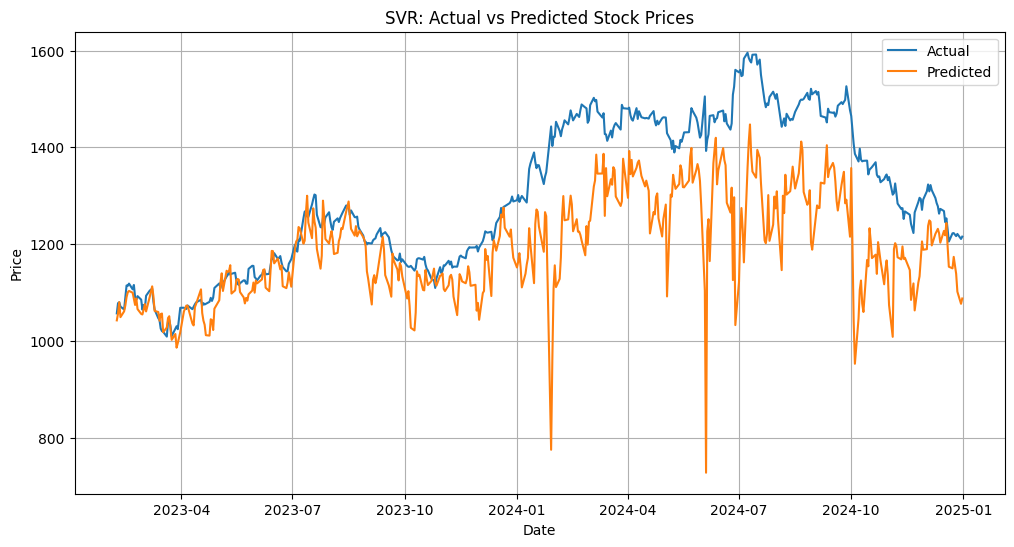

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()
plt.title("SVR: Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


In [21]:
# Train the SVR model with different kernel

from sklearn.svm import SVR

svr_model1 = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_model1.fit(X_train_scaled, y_train)


SVR(kernel='linear')

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred1 = svr_model1.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred1))
r2 = r2_score(y_test, y_pred1)

print(f"SVR Test RMSE: {rmse:.2f}")
print(f"SVR Test R² Score: {r2:.4f}")


SVR Test RMSE: 8.63
SVR Test R² Score: 0.9968


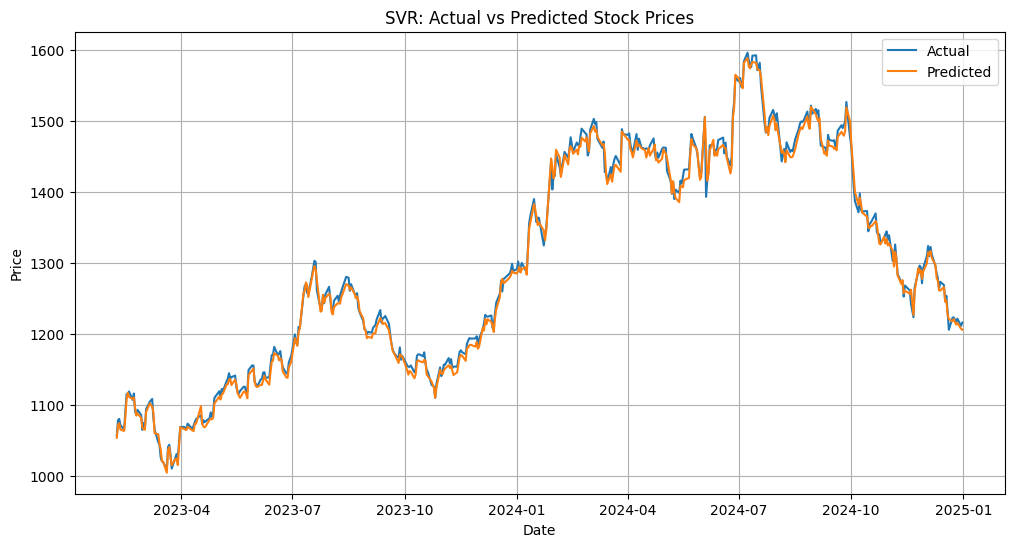

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred1, label="Predicted")
plt.legend()
plt.title("SVR: Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


In [24]:
# Grid SearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define pipeline: scaling + SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='linear'))
])

# Define hyperparameter grid
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5, 1]
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Minimize MSE
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Run grid search on training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

# Predict using best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"SVR (Best) Test RMSE: {rmse:.2f}")
print(f"SVR (Best) Test R² Score: {r2:.4f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 1}
Best Score (Negative MSE): -17.41901287352139
SVR (Best) Test RMSE: 30.28
SVR (Best) Test R² Score: 0.9987


In [26]:
import joblib

joblib.dump(best_model, "C://GITHUB CODES//stock-predictor-ml//models//svr_best_model.pk1")

['C://GITHUB CODES//stock-predictor-ml//models//svr_best_model.pk1']

In [ ]:
# Load the saved model
#loaded_model = joblib.load('models/svr_best_model.pkl')

# Use it
#predictions = loaded_model.predict(X_test)
